In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import numpy as np
from scipy.stats import norm
from scipy.stats import t


In [22]:
url ='https://lms.skillfactory.ru/assets/courseware/v1/f9f05ba6ecb36996a8ec5c6e89cd2a75/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_data.zip'
ab_data = pd.read_csv(url)

In [23]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [24]:
ab_data.info()
# нет пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [25]:
# нужно перевести столбец с информацией о дате события (timestamp) в формат datetime
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

In [26]:
# необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество 
# пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


### 4.1. Рассчитайте конверсию на каждый день. Результат занесите в столбец conversion. Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? 

In [27]:
daily_data['conversion'] = daily_data.converted/daily_data.users_count * 100
round(daily_data[(daily_data.timestamp == '2017-01-05') & (daily_data.group == 'A')].conversion.iloc[0], 2)

12.32

In [28]:
display(daily_data.head())

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


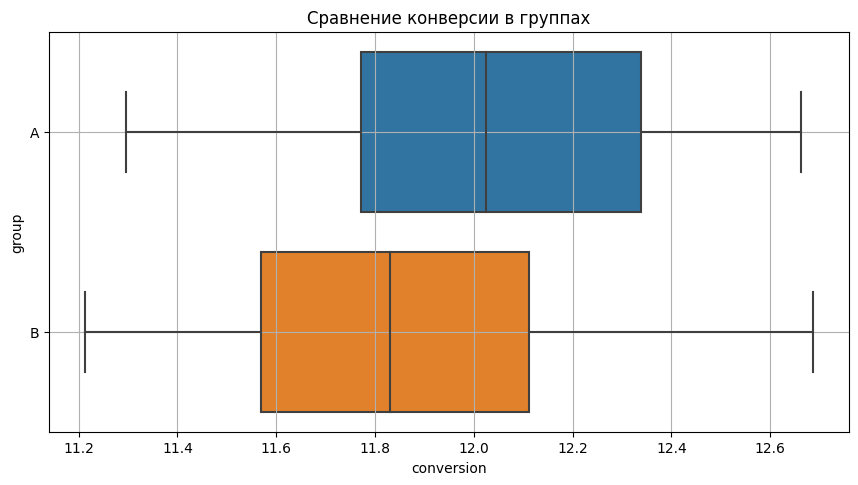

In [29]:
# построим диаграмму boxplot для визуального сравнения параметров
# распределения ежедневной конверсии по группам
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

In [30]:
# вычислим средний и медианный показатель конверсии в контрольной и тестовой группе
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


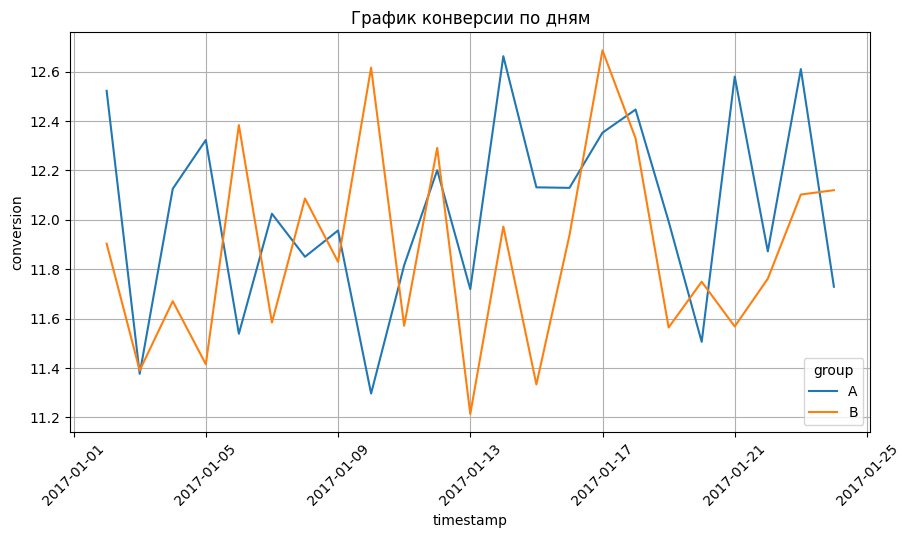

In [31]:
# изменения показателей ежедневной конверсии в каждой группе во времени
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

In [32]:
# создадим в полученной таблице новый столбец cum_users_count,
# в который запишем результат работы метода cumsum() по столбцу users_count:

# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

C:\Users\insps\AppData\Local\Temp\ipykernel_14728\4031684885.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


In [33]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


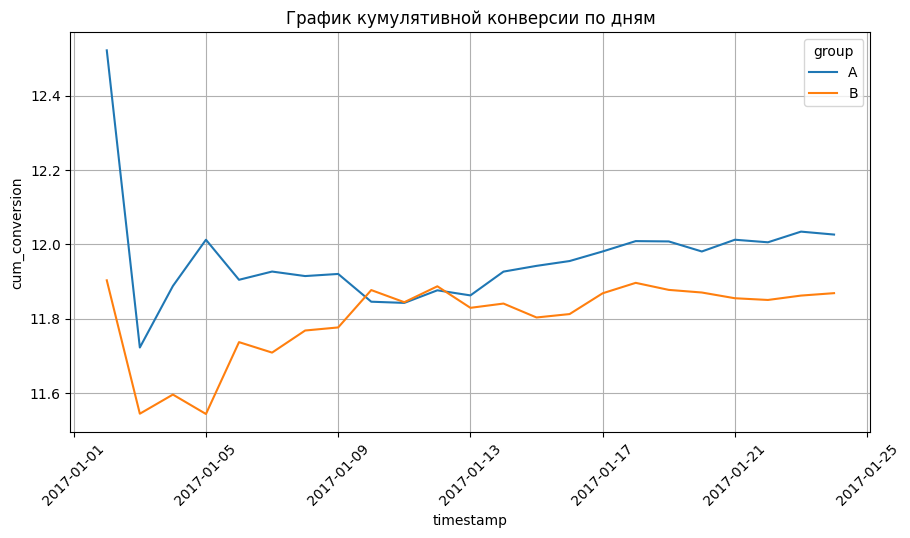

In [34]:
# построим графики кумулятивной конверсии по дням в каждой группе

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

## Зададния 4.6-4.9

Каждая таблица имеет следующие поля:

date — дата наблюдения;

cid — идентификатор посетителя;

transactions — количество совершённых целевых действий (транзакций);

revenue — сумма покупки;

group — группа (тестовая — А, контрольная — B).

In [35]:
sample_a = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/c3bcdf8e84ea8fc45d08fe987299dea2/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_test-redesign_sample_a.zip')
sample_b = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/91524f30dbacb1a751a1d4a935b8f7bb/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_test-redesign_sample_b.zip')

In [36]:
sample_a.tail()

,date,cid,transactions,revenue,group
61566,2020-11-23,9.986289e+08,0,0,A
61567,2020-11-23,9.989196e+08,0,0,A
61568,2020-11-23,9.990631e+08,0,0,A
61569,2020-11-23,9.994210e+07,0,0,A
61570,2020-11-23,9.994748e+08,0,0,A


In [37]:
sample_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61571 entries, 0 to 61570
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          61571 non-null  object 
 1   cid           61571 non-null  float64
 2   transactions  61571 non-null  int64  
 3   revenue       61571 non-null  int64  
 4   group         61571 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.3+ MB


### Задание 4.6

Постройте таблицу со следующими ежедневными показателями:
- количество посетителей сайта;
- суммарное число транзакций;
- общая сумма покупок (выручка).
Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.

Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?

In [38]:
sample_a.date = pd.to_datetime(sample_a.date, format='%Y-%m-%d')
daily_a = sample_a.groupby('date').agg({'cid': 'count', 'transactions': 'sum', 'revenue': 'sum'}).reset_index()
sample_b.date = pd.to_datetime(sample_b.date, format='%Y-%m-%d')
daily_b = sample_b.groupby('date').agg({'cid': 'count', 'transactions': 'sum', 'revenue': 'sum'}).reset_index()

daily_a[daily_a.date == '2020-11-08']

,date,cid,transactions,revenue
2,2020-11-08,3354,25,846051


### Задание 4.7

Добавьте в каждую из таблиц кумулятивные метрики:

- кумулятивное количество посетителей сайта;
- кумулятивное суммарное число транзакций;
- кумулятивная общая сумма покупок (кумулятивная выручка).
- 
Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста?

In [39]:
daily_a['cum_cid'] = daily_a.cid.cumsum()
daily_a['cum_transactions'] = daily_a.transactions.cumsum()
daily_a['cum_revenue'] = daily_a.revenue.cumsum()
daily_a['cum_conversion'] = daily_a.cum_transactions/daily_a.cum_cid * 100
daily_a['cum_aov'] = round(daily_a.cum_revenue/daily_a.cum_transactions, 2)
round(daily_a.cum_conversion.mean(), 2)

0.71

In [40]:
daily_b['cum_cid'] = daily_b.cid.cumsum()
daily_b['cum_transactions'] = daily_b.transactions.cumsum()
daily_b['cum_revenue'] = daily_b.revenue.cumsum()
daily_b['cum_conversion'] = daily_b.cum_transactions/daily_b.cum_cid * 100
daily_b['cum_aov'] = round(daily_b.cum_revenue/daily_b.cum_transactions, 2)
round(daily_b.cum_conversion.mean(), 2)

0.76

### Задание 4.8

Постройте графики кумулятивной конверсии в каждой группе. Какие выводы по ним вы можете сделать?

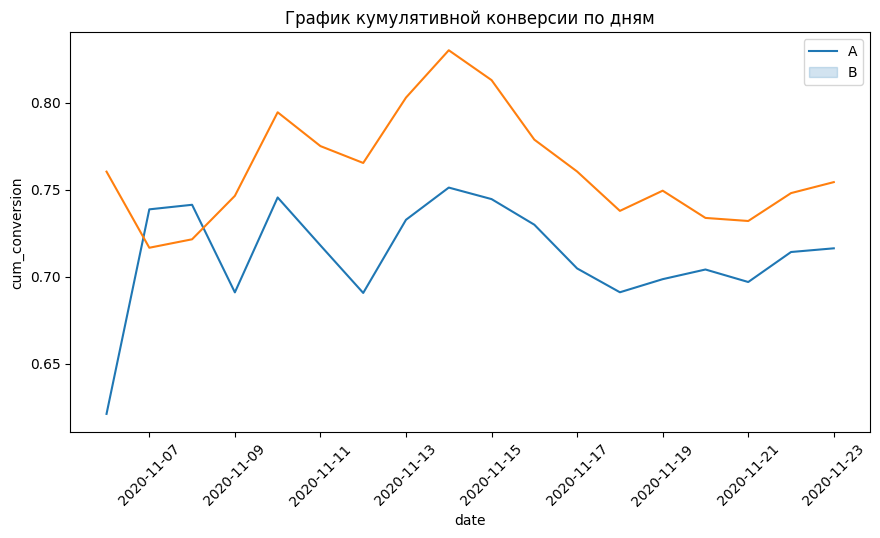

In [41]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])

sns.lineplot(x='date', y='cum_conversion', data=daily_a, ax=ax)
sns.lineplot(x='date', y='cum_conversion', data=daily_b, ax=ax)

ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
plt.legend(labels=['A', 'B']);

### Задание 4.9

Постройте графики кумулятивного среднего чека в каждой группе

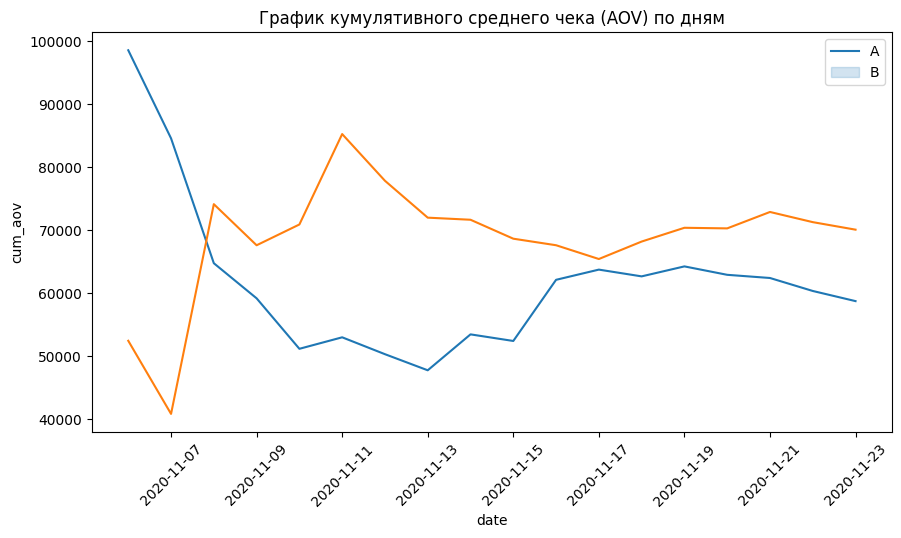

In [42]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])

sns.lineplot(x='date', y='cum_aov', data=daily_a, ax=ax)
sns.lineplot(x='date', y='cum_aov', data=daily_b, ax=ax)

ax.set_title('График кумулятивного среднего чека (AOV) по дням')
ax.xaxis.set_tick_params(rotation = 45)
plt.legend(labels=['A', 'B']);

In [43]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


In [44]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.

In [45]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


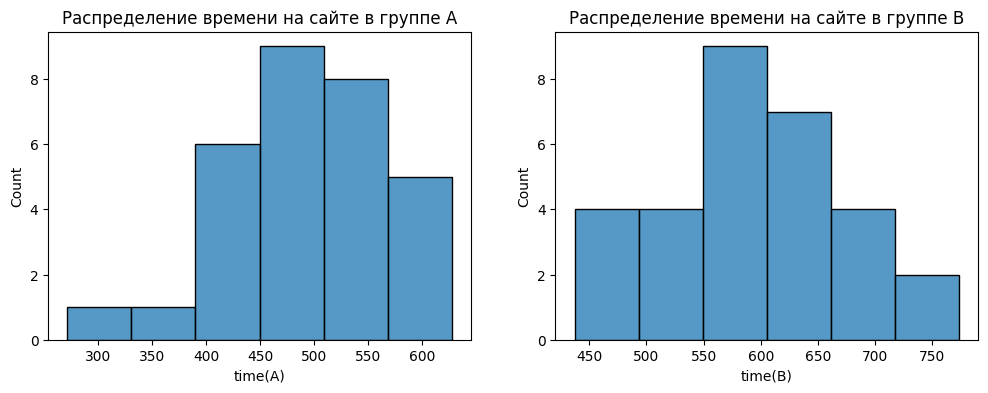

In [46]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

проверим гипотезу о нормальности обоих распределений с помощью критерия **Шапиро-Уилка**. 

In [47]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


можем воспользоваться **T-тестом** для того, чтобы сравнить среднее время посещения сайта в группах

In [48]:
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


### Задание 5.2

Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе: Конверсия в группе А меньше, чем конверсия в группе B. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите 0.05.

In [49]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А меньше, чем конверсия в группе B'
alpha = 0.05

_, p_value = proportions_ztest(
    count=np.array([sample_a.transactions.sum(), sample_b.transactions.sum()]), #число "успехов"
    nobs=np.array([sample_a.cid.count(), sample_b.cid.count()]), #общее число наблюдений
    alternative='smaller',
)
print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


### Задание 5.3

Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите .

In [50]:
daily_a.head(1)

,date,cid,transactions,revenue,cum_cid,cum_transactions,cum_revenue,cum_conversion,cum_aov
0,2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.94


In [51]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1

shapiro_result_a = shapiro(daily_a.revenue/daily_a.transactions)
shapiro_result_b = shapiro(daily_b.revenue/daily_b.transactions)
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.01
p-value группы B 0.02
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


### Задание 5.4

Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе: Ежедневный средний чек в группе А меньше, чем в группе B. Используйте функцию mannwhitneyu() из модуля scipy.stats. В качестве уровня значимости возьмите 0.05

In [52]:
H0 = 'Средние чеки в группах одинаковы'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.1

_, pvalue = mannwhitneyu(
    x=daily_a.revenue/daily_a.transactions,
    y=daily_b.revenue/daily_b.transactions, 
    alternative='less'
)
print('p-value:', round(pvalue, 2))
 
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.09
Отвергаем нулевую гипотезу. Средние чеки в группах одинаковы
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


### Построение доверительного интервала для истинного среднего при известном стандартном отклонении


In [53]:
n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [54]:
z_crit = -norm.ppf(alpha/2) # z критическое

In [55]:
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval))

Доверительный интервал: (12180, 20020)


In [56]:
print('Доверительный интервал: {}'.format(confinterval(36, 16100, 12000, 0.95)))


Доверительный интервал: (12180.07, 20019.93)


### Задание 6.5

Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

In [57]:
print(f'значение z-критического {round(-norm.ppf((1-0.9)/2), 2)}')

значение z-критического 1.64


In [58]:
from helpers.confinterval import confinterval

In [59]:
print(confinterval(64, 12.35, 2.4, 0.9))

(12, 13)


Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

In [60]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

Найти значение t-критического для любого уровня значимости можно, используя функцию t.ppf() из модуля scipy.stats

In [61]:
t_crit = -t.ppf(alpha/2, k) # t-критическое

In [62]:
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (1778, 2222)


### Задание 6.6

Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил $ 3 540. Также известно выборочное отклонение величины подоходного налога, равное $ 1 150.

Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год

In [63]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [64]:
t_crit = -t.ppf(alpha/2, k) # t-критическое

In [19]:
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (3146, 3934)


нужно научиться строить **доверительный интервал для пропорции**

In [66]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

объявим функцию **proportions_conf_interval()**. У данной функции будет три аргумента: n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой

In [2]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [78]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


Создадим функцию **diff_proportions_conf_interval()** со следующими аргументами: n — список из размеров выборки для групп А и B соответственно, xp — список из выборочных пропорций для групп А и B соответственно и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [77]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [69]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


### Задание 6.9

Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.

In [3]:
n_sample = 189
n_pos = 132
prop = n_pos/n_sample
print(f'Выборочная пропорция положительных комментариев равна {prop}')

Выборочная пропорция положительных комментариев равна 0.6984126984126984


In [4]:
proportions_conf_interval(n_sample, prop, 0.9)

(64.35, 75.33)

### Задание 6.10

Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. Есть два варианта отображения страницы: с товарными рекомендациями «Хиты продаж» и персональными, подобранными под интерес конкретно этого пользователя. Метрикой является конверсия действия «добавить в корзину товар из рекомендаций». Были собраны следующие данные:

А (Персональные скидки) - 45 - 1000

B (Хиты продаж) - 50 - 1000

Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.

In [98]:
n = [1000, 1000]
# выборочная пропорция групп A и B
xp = [0.045, 0.05]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-1.36, 2.36)
